# Analyzing Assessed Value of the Downtown Mall

## Goals: 

    *Provide descriptive statistics of assessed value over time for the City of Charlottesville's downtown mall

    *Map and chart assessed values over time

## Step 1: Aquire Data

### Assessment Values
    Charlottesville's Open Data Portal : http://opendata.charlottesville.org/

    Real Estate (All Assessments) Dataset : http://opendata.charlottesville.org/datasets/real-estate-all-assessments

        * On the Real Estate dataset page, in the upper right corner of the window under the map click the APIs             drop down
        * Copy the GeoJSON link
        * Use the GeoJSON link to pull data directly from the Open Data portal using the code below

    Parcel Area Data : http://opendata.charlottesville.org/datasets/parcel-boundary-area

### List of properties to use in analysis

Charlottesville GIS Viewer: https://gisweb.charlottesville.org/GisViewer/

    * Under Map option, turn on 'Parcels & Buildings' > 'Parcels'. Turn everything else off.

    * Zoom to area of interest on map

    * Under 'Tools' select 'Identify'

    * In 'Identify' toolbar select 'Custom Shape' and under 'Layer' select 'Parcels'

    * Using mouse on map, click boundary around area of interest

    * A list will appear in the left panel of the web page

    * In the panel click 'Tools' > 'Export All to Excel'

    * A window named 'Export Results' will open when your download is ready.

    * Click 'View Export' and save file to your project directory

<img src="https://github.com/strmwtr/downtown_assessments/blob/master/img/getting_pin_list.png?raw=true">

# Step 2: Prepare Data

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import requests
import folium

%matplotlib inline

## Import .xls retrieved from the GIS Viewer into pandas

In [2]:
#Path to the .xls retrieve from the GIS Viewer
f = r'./data/pin_exp.xls'

#Create a dataframe that reads the .xls file
df = pd.read_excel(f)

#### Remove all MULTIPIN parcels from df

In [3]:
#Identify all rows in df where MULTIPIN column is not equal to 1
not_multipin = df['MULTIPIN'] != 1
#Create a new dataframe that only contains the rows identified in not_multipin
df = df[not_multipin]
#df.head()

## Access json file for parcel areas

In [4]:
formatted_gpins = [str(x) for x in df['GPIN'].unique()]
formatted_gpins = formatted_gpins
formatted_gpins = ','.join(formatted_gpins)

parcel_area_url = f"https://gisweb.charlottesville.org/arcgis/rest/services/OpenData_1/MapServer/43/query?where=GPIN%20in%20({formatted_gpins})&outFields=*&outSR=4326&f=json"

print(parcel_area_url)

https://gisweb.charlottesville.org/arcgis/rest/services/OpenData_1/MapServer/43/query?where=GPIN%20in%20(7309,14744,6656,7426,7021,6984,7197,6819,6876,7447,7029,6724,7511,7484,7042,7005,6807,7515,7543,6923,17202,7128,7541,7199,6805,7120,7111,6877,7047,6569,7053,6958,6674,7082,7037,6668,6930,7063,6666,7213,6740,7078,6897,7279,7091,6726,6966,7104,6806,6869,6633,6881,7272,7068,6703,6947,6832,6625,7141,6604,6696,7162,6393,6694,7171,6848,7346,6537,6662,6493,7017,7330,7025,6655,7033,6644,6861,6689,6267,7232,6979,6918,7059,6938,7249,7070,7259,7087,7096,7266,7103,7275,7308,7163,7510,7319,7329,7339,7185,7348,7072,7198,7358,7207,7374,7390,7441,7456,7471,7664,7482,7717,7507,7524,17098,17097,7184,7476)&outFields=*&outSR=4326&f=json


## Preparing annual assessment data

Charlottesville's Open Data Portal : http://opendata.charlottesville.org/

Real Estate (All Assessments) Dataset : http://opendata.charlottesville.org/datasets/real-estate-all-assessments

* On the Real Estate dataset page, in the upper right corner of the window under the map click the 'API Explorer' tab
* Copy the Query URL link and augment the link to match your query
* Use the augmented link to pull data directly from the Open Data portal using the code below

In [5]:
formatted_pins = [f'%27{x}%27' for x in df['PIN'].unique()]
formatted_pins_1 = formatted_pins
formatted_pins_1 = ','.join(formatted_pins_1)

assessment_url = f"https://gisweb.charlottesville.org/arcgis/rest/services/OpenData_2/MapServer/2/query?where=UPPER(ParcelNumber)%20in%20({formatted_pins_1})%20&outFields=ParcelNumber,LandValue,ImprovementValue,TotalValue,TaxYear&outSR=4326&f=json"

assessment_request = requests.get(assessment_url)

d1 = assessment_request.json()

After testing the requests.get(url), I can request up to 120 parcels at a time before recieving a 404 Error. I have 126 parcels of interest. I will break my request up into 2 parts, [:75] and [75:].

## Create data series based on features and combine data frames into a single df

In [6]:
df1 = pd.DataFrame(d1['features'])

## Create a single data frame based on combined series data

In [7]:
assessments = pd.DataFrame([x for x in df1['attributes']], dtype = 'object')
assessments = assessments.astype({'TaxYear': 'int64', 'ImprovementValue': 'int64','LandValue': 'int64','TotalValue': 'int64', 'ParcelNumber': 'str'})
#assessments.head()

## Create data frame from df that holds PIN and GPIN. Will be used to joined assessments, so that parcel area can be joined with assessments

In [8]:
df_key = pd.DataFrame(df[['PIN','GPIN']], dtype = 'str')
#df_key.head()

In [9]:
d = pd.merge(assessments, df_key, how='inner', left_on=['ParcelNumber'], right_on=['PIN'])
#print(assessments.shape, d.shape)

# Step 3: Analyze

In [10]:
#Create data frame of assessed values for all parcels by specified year
year_min = int(d['TaxYear'].min())
year_max = int(d['TaxYear'].max())
years = (x for x in range(year_min, year_max+1))
#total_val_col = d['TotalValue'][d['TaxYear'] == 2019].mean()
assessment_chart_list = []
for x in years:
    year_col = x
    land_col_mean = d['LandValue'][d['TaxYear'] == x].mean()
    imp_col_mean = d['ImprovementValue'][d['TaxYear'] == x].mean()
    total_col_mean = d['TotalValue'][d['TaxYear'] == x].mean()
    
    land_col_min = d['LandValue'][d['TaxYear'] == x].min()
    imp_col_min = d['ImprovementValue'][d['TaxYear'] == x].min()
    total_col_min = d['TotalValue'][d['TaxYear'] == x].min()
    
    land_col_max = d['LandValue'][d['TaxYear'] == x].max()
    imp_col_max = d['ImprovementValue'][d['TaxYear'] == x].max()
    total_col_max = d['TotalValue'][d['TaxYear'] == x].max()
    
    assessment_chart_list.append(
        [year_col, land_col_mean, imp_col_mean, total_col_mean, land_col_min, imp_col_min, 
         total_col_min, land_col_max, imp_col_max, total_col_max])
assessment_chart_cols = ['Tax Year', 'Mean Land Value', 'Mean Improvement Value', 'Mean Total Value',
    'Min Land Value', 'Min Improvement Value', 'Min Total Value', 'Max Land Value', 'Max Improvement Value', 
    'Max Total Value']
assessment_chart_df = pd.DataFrame(assessment_chart_list, columns = assessment_chart_cols)
#assessment_chart_df

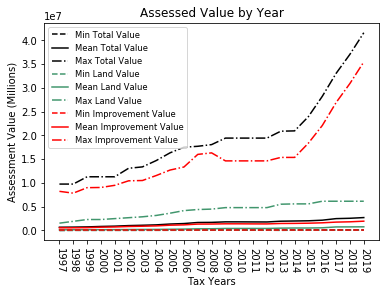

In [11]:
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Min Total Value'], linestyle = '--', color = '#000000', label='Min Total Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Mean Total Value'], linestyle = '-', color = '#000000', label='Mean Total Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Max Total Value'], linestyle = '-.', color = '#000000', label='Max Total Value')

plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Min Land Value'], linestyle = '--', color = '#41966d',  label='Min Land Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Mean Land Value'], linestyle = '-', color = '#41966d', label='Mean Land Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Max Land Value'],  linestyle = '-.', color = '#41966d', label='Max Land Value')

plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Min Improvement Value'], linestyle = '--', color = '#ff0000', label='Min Improvement Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Mean Improvement Value'], linestyle = '-', color = '#ff0000', label='Mean Improvement Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Max Improvement Value'], linestyle = '-.', color = '#ff0000', label='Max Improvement Value')

plt.title('Assessed Value by Year')
plt.xlabel('Tax Years')
plt.ylabel('Assessment Value (Millions)')

plt.xticks(range(assessment_chart_df['Tax Year'].min(), assessment_chart_df['Tax Year'].max()+1), rotation=270)
plt.yticks(range(0, int(assessment_chart_df['Max Total Value'].max()), 5000000))

plt.legend(fontsize = 'small')
plt.savefig('plot.png', dpi=300, edgecolor = 'w', orientation='landscape')

In [22]:
formatted_gpins = [str(x) for x in df['GPIN'].unique()]
formatted_gpins = formatted_gpins
formatted_gpins = ','.join(formatted_gpins)

#Query url
parcel_url = f'https://opendata.arcgis.com/datasets/320d465ddf0d498796da6491e21f6dde_43.geojson?where=GPIN%20in%20({formatted_gpins})'

parcel_url_request = requests.get(parcel_url)
print(parcel_url_request)
parcel_url_json = parcel

<Response [200]>


In [19]:
def total_value_by_year(year):
    tv_df = d[['GPIN','TotalValue']][d['TaxYear'] == year]
    tv_df = tv_df.astype({'GPIN': 'int', 'TotalValue': 'int'})
    return tv_df


total_value_by_year(1997)

,GPIN,TotalValue
22,6861,3342200
45,6869,2030900
68,7068,117600
91,7120,162100
120,6958,2288800
143,6984,422400
166,7021,592700
189,7197,654100
212,7029,197700
235,7042,252400


In [20]:
m = folium.Map(location=[38.03090, -78.48044], zoom_start=17, tiles='OpenStreetMap')
folium.Choropleth(
    geo_data = parcel_url, 
    data=total_value_by_year(1997), 
    columns=['GPIN', 'TotalValue'], 
    key_on='GPIN', 
    bins=9,
    fill_color='YlGn', 
    nan_fill_color='black', 
    fill_opacity=0.8, 
    nan_fill_opacity=1, 
    line_color='black', 
    line_weight=1, 
    line_opacity=1, 
    name='Assessed Value',
    legend_name='Total Assessed Value 1997', 
).add_to(m)
m

# Map Total Assessed Value by Parcel via folium
# Do it for each year
# Create time lapse of maps